# Optimize the models' hyperparameter

In this notebook, there is only one goal: optimize the hyperparameters of the models. 

In [1]:
# import all of the packages that will be used

# basic packages for data processing
import pandas as pd
import numpy as np

# packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# packages to interpret the training result
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

## Load the dataset

In [2]:
features = pd.read_csv('Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv').squeeze()
features = features[:6]

In [3]:
columns = features.tolist() +  ['label']

luflow2020 = pd.read_csv('Dataset/dataset_cleaned/LUFlow.csv', usecols=columns)
luflow2020.shape

(1759480, 7)

## Processing before training

### Down sampling the dataset

As grid search is basically brute force all combinations of hyperparameters that are defined in the hyperparameter space, it is an expensive process. To speed up the process, only 5% of the training dataset will be used. 

In [4]:
luflow2020 = luflow2020.sample(frac=0.05).reset_index(drop=True)
print('Class distribution: ')
luflow2020['label'].value_counts()

Class distribution: 


malicious    44278
benign       43696
Name: label, dtype: int64

### Split the dataset

Split the features and the output variable into two dataframe, and further split them into testing and training dataset. The ratio between the training and testing dataset is 8:2 (i.e. 80% for training and 20% for testing). The training dataset will be used to optimize the models' hyperparameter while the testing dataset will give us a first glance on the accuracy of the optimized models. 

In [5]:
luflow2020_X = luflow2020.drop('label', axis=1).copy()
luflow2020_y = luflow2020['label'].copy()

luflow2020_train_X, luflow2020_test_X, luflow2020_train_y, luflow2020_test_y = train_test_split(luflow2020_X, luflow2020_y, test_size=0.3)

### Data scaling

In [6]:
scalar = StandardScaler()

luflow2020_train_X_scaled = scalar.fit_transform(luflow2020_train_X)
luflow2020_test_X_scaled = scalar.transform(luflow2020_test_X)

## Optimize Hyperparameter of each models

### Decision Tree

The decision tree will be optimized by tuning the `ccp_alpha` value. A for loop is being used to loop through multiple `ccp_alpha` values and the alpha value that gives the highest accuracy score will be selected. 

Wall time: 42 s


<AxesSubplot:xlabel='alpha'>

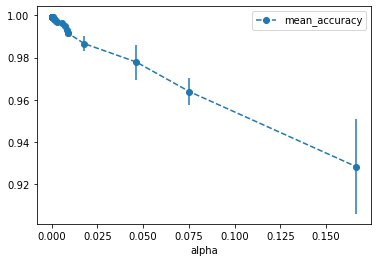

In [7]:
%%time

decision_tree = tree.DecisionTreeClassifier(criterion='entropy')
path = decision_tree.cost_complexity_pruning_path(luflow2020_train_X_scaled, luflow2020_train_y)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # exlude the maximum value

alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp_alpha)
    scores = cross_val_score(decision_tree, luflow2020_train_X_scaled, luflow2020_train_y, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])


# Plot a graph of the means and standard deviations of the scores for each candidate
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                    y='mean_accuracy', 
                    yerr='std', 
                    marker='o', 
                    linestyle='--')

Build the optimal tree and evaluate its accuracy

In [8]:
# print the optimum alpha value
ideal_ccp_alpha = alpha_results.sort_values(by=['mean_accuracy'], ascending=False).iloc[0]
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'])
print(f"Optimal alpha value: {ideal_ccp_alpha}")

# build the optimum tree
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ideal_ccp_alpha)
decision_tree.fit(luflow2020_train_X_scaled, luflow2020_train_y)

prediction = decision_tree.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Optimal alpha value: 0.00013808459751681997
Accuracy: 0.99856


## Random Forest

In [9]:
%%time

parameter_space = [
    {'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 0.0001, 0.00005, 0.0002], 
    'min_samples_split': [12, 0.0005, 0.0001], 
    'n_estimators': [100, 200, 300]
    }
]

optimal_rf = GridSearchCV(
                        RandomForestClassifier(),
                        parameter_space, 
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=0
)

optimal_rf.fit(luflow2020_train_X_scaled, luflow2020_train_y)
rf_optimal_params = optimal_rf.best_params_
print(f"Optimum hyperparameters: \n{rf_optimal_params}")

Optimum hyperparameters: 
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5e-05, 'min_samples_split': 12, 'n_estimators': 300}
Wall time: 38min 58s


Make prediction using the optimum model and evaluate its accuracy

In [10]:
prediction = optimal_rf.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99917


## Support Vector Machine

In [11]:
%%time
parameter_space = [
    {'C': [1, 10, 100],
    'gamma': ['scale', 1, 0.1, 'auto'],
    'kernel': ['rbf', 'linear', 'sigmoid']}
]

optimal_svm = GridSearchCV(
                        SVC(),
                        parameter_space, 
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=0
)

optimal_svm.fit(luflow2020_train_X_scaled, luflow2020_train_y)
svm_optimal_params = optimal_svm.best_params_
print(f"Optimum hyperparameters: \n{svm_optimal_params}")

Optimum hyperparameters: 
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Wall time: 1h 35min 37s


Make prediction using the optimum model and evaluate its accuracy

In [12]:
prediction = optimal_svm.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99432


## Naive Bayes

In [13]:
%%time

parameter_space = [
    {'var_smoothing': np.logspace(0, -9, num=100)}
]

optimal_nb = GridSearchCV(
                        GaussianNB(),
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_nb.fit(luflow2020_train_X_scaled, luflow2020_train_y)
nb_optimal_params = optimal_nb.best_params_
print(f"Optimum hyperparameters: \n{nb_optimal_params}")

Optimum hyperparameters: 
{'var_smoothing': 8.111308307896873e-06}
Wall time: 26.8 s


Make prediction using the optimum model and evaluate its accuracy

In [14]:
prediction = optimal_nb.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.72125


## Artificial Neural Network

In [15]:
%%time

parameter_space = [
    {'hidden_layer_sizes': [(30,), (20,), (10,), (40,), (50,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.00001]}
]

ann = MLPClassifier(max_iter=500)

optimal_ann = GridSearchCV(
                        ann,
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_ann.fit(luflow2020_train_X_scaled, luflow2020_train_y)
ann_optimal_params = optimal_ann.best_params_
print(f"Optimum hyperparameters: \n{ann_optimal_params}")

Optimum hyperparameters: 
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (40,), 'solver': 'adam'}
Wall time: 1h 43min 36s


In [16]:
prediction = optimal_ann.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99326


## Deep Neural Network

In [17]:
%%time

parameter_space = [
    {'hidden_layer_sizes': [(10,10, 10), (12, 12, 12), (8, 8, 8), (8, 8, 8, 8), (10, 10, 10, 10)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.00001, 0.001]}
]

dnn = MLPClassifier(max_iter=500)

optimal_dnn = GridSearchCV(
                        dnn,
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_dnn.fit(luflow2020_train_X_scaled, luflow2020_train_y)
dnn_optimal_params = optimal_dnn.best_params_
print(f"Optimum hyperparameters: \n{dnn_optimal_params}")

Optimum hyperparameters: 
{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
Wall time: 1h 30min 54s


In [18]:
prediction = optimal_dnn.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99625
